## Homework 4

Use this notebook as a starter

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from rich import print #for pretty print!
from rich.progress import track



%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [3]:
#Already downloaded this!
#!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [4]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [9]:
cat_cols = list(df.dtypes[df.dtypes == 'object'].index)
num_cols = list(df.dtypes[df.dtypes == 'float'].index) + list(df.dtypes[df.dtypes == 'int'].index)
print(f"{df.columns.shape[0]} columns: {df.columns.to_list()}")
print(f"{len(cat_cols)} categorical variables: {cat_cols}")
print(f"{len(num_cols)} numerical variables: {num_cols}")

14 columns: ['seniority', 'home', 'time', 'age', 'marital', 'records', 'job', 'expenses', 
'income', 'assets', 'debt', 'amount', 'price', 'default']

4 categorical variables: ['home', 'marital', 'records', 'job']

10 numerical variables: ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 
'amount', 'price', 'default']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [10]:
#Data split
from sklearn.model_selection import train_test_split
#test rich progress bar! Process too short to use here, try later
#for n in track(range(100), description="Processing..."):
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Do not know what "use numerical variable as score" mean...

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values
#fpr, tpr, thresholds = metrics.roc_curve( y_test, 
scores=[]
for col in num_cols[0:-2]:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[col])
    
    #print(col)
    #print(df_train[col])
    if (auc(fpr,tpr) < 0.5):
        fpr, tpr, thresholds = roc_curve(y_train, -df_train[col])
        print(col, " ",auc(fpr,tpr)) #
    else:
        print(col, " ",auc(fpr,tpr))
    #auc(df_train[col].values, y_train)

# base=num_cols+cat_cols
# def prepare_X(df,base):
#     df_num = df[base]
#     df_num = df_num.fillna(0)
#     X = df_num.values
#     return X
# X_train = prepare_X(df_train,base)

# print(df_train)
# col="home"
# fpr, tpr = roc_curve(y_train, df_train[:,col])



seniority   0.7093778624491943

time   0.5608662489595051

age   0.5732933272499939

expenses   0.5009184217217011

income   0.682006666132633

assets   0.6486042567122802

debt   0.5047829675783548

amount   0.5910773431595518

In [12]:
# ANSWER: seniority

Which categorical variable (among the following 4) has the highest AUC?

- seniority (THIS ONE)
- time 
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [13]:

base_cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# df_full_train, df_test = train_test_split(df[base_cols], test_size=0.2, random_state=1)
# df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# df_train = df_train.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

dv = DictVectorizer(sparse=False)
train_dict = df_train[base_cols].to_dict(orient='records')
#train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[base_cols].to_dict(orient='records')
#val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
lr = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000)
lr.fit(X_train, y_train)
y_pred= lr.predict_proba(X_val)[:,1] # REMEMBER I AM PREDICTING PROBABILITIES!!!!!
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_val,y_pred).round(3))
#fpr, tpr, thresholds = roc_curve(y_val, y_pred)

#print(round(auc(fpr, tpr),3))


0.812

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812 (THIS ONE)

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


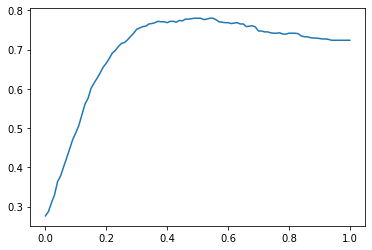

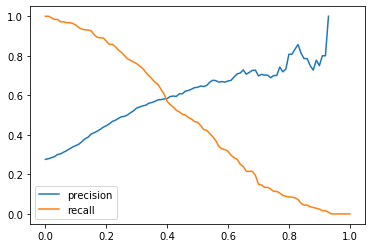

In [14]:
scores = []
from sklearn.metrics import accuracy_score


thresholds=np.linspace(0,1,101)

for t in thresholds:
    score = accuracy_score(y_val,y_pred >= t)
    #print(f"threshold: {t} and  score: {score}")
    scores.append(score)
fig1=plt.figure()
plt.plot(thresholds, scores)
#Now do this for precision and recall
scores=[]
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp/(tp + fp) #precision
    r = tp/(tp + fn) #recall
    
    #scores.append((t, tp, fp, fn, tn))
    scores.append((t, p,r))
#columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
columns=['threshold',"p","r"]
df_scores = pd.DataFrame(scores, columns=columns)

#df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
#df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
fig2=plt.figure()
#plt.plot(df_scores.threshold, df_scores['tpr'].values, label='TPR')
#plt.plot(df_scores.threshold, df_scores['fpr'].values, label='FPR')
plt.plot(df_scores.threshold.values,df_scores.p.values,label="precision")
plt.plot(df_scores.threshold.values,df_scores.r.values,label="recall")
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6 (THIS ONE)
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


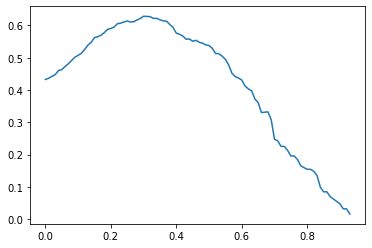

In [29]:
F1 = 2* df_scores.p * df_scores.r/(df_scores.p + df_scores.r)
F1
fig3=plt.figure()
plt.plot(df_scores.threshold.values,F1,label="F1")


At which threshold F1 is maximal?

- 0.1
- 0.3 (THiS ONE)
- 0.5 
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [27]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm #this is apparently a progress bar. I think I prefer rich

def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    #dicts = df[cat_cols + num_cols].to_dict(orient='records')
    dicts = df[base_cols].to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred
#NEED TO FIX BELOW
#for n in track(range(100), description="Processing..."):
#for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
#print("mean = %.3f, std = %.3f"%(np.mean(scores), np.std(scores)))
print(np.std(scores))
#     scores = []

#NO C variation yet!
# for train_idx, val_idx in kfold.split(df_full_train):
#         df_train = df_full_train.iloc[train_idx]
#         df_val = df_full_train.iloc[val_idx]

#         y_train = df_full_train.default.values
#         y_val = df_val.default.values

#         dv, model = train(df_train, y_train, C=C)
#         y_pred = predict(df_val, dv, model)

#         auc = roc_auc_score(y_val, y_pred)
#         scores.append(auc)

#     print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
#     #print(np.mean(scores), np.std(scores))

Index(['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
       'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'],
      dtype='object')

0.016626317167226057

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014 (THIS ONE, I THINK...)
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [28]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


    

C=0.01 0.824 +- 0.000

C=0.01 0.828 +- 0.004

C=0.01 0.813 +- 0.020

C=0.01 0.814 +- 0.018

C=0.01 0.811 +- 0.017

C=0.1 0.824 +- 0.000

C=0.1 0.828 +- 0.004

C=0.1 0.813 +- 0.020

C=0.1 0.814 +- 0.018

C=0.1 0.811 +- 0.017

C=1 0.824 +- 0.000

C=1 0.828 +- 0.004

C=1 0.813 +- 0.020

C=1 0.814 +- 0.018

C=1 0.811 +- 0.017

C=10 0.824 +- 0.000

C=10 0.828 +- 0.004

C=10 0.813 +- 0.020

C=10 0.814 +- 0.018

C=10 0.811 +- 0.017

Which C leads to the best mean score?

- 0.01 (THIS ONE)
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.